In [1]:
from pypfopt import expected_returns, EfficientSemivariance, EfficientCVaR, EfficientCDaR, HRPOpt, BlackLittermanModel, black_litterman
from pypfopt.risk_models import CovarianceShrinkage, sample_cov
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import *
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
import seaborn as sns
from datetime import *
from dateutil.relativedelta import relativedelta

In [2]:
cutoff_date = date.today() - relativedelta(years = 2)

Downloading historical prices

In [3]:
tickers = ['AEE', 'AEP', 'CMS', 'D', 'DTE', 'DUK', 'ED', 'ES', 'EVRG', 'LNT']
prices = yf.download(tickers, period = '10y' , progress = False)['Close'].dropna()
prices

YF.download() has changed argument auto_adjust default to True


Ticker,AEE,AEP,CMS,D,DTE,DUK,ED,ES,EVRG,LNT
Date,,,,,,,,,,
2015-04-13,30.692537,38.945683,25.667376,46.474251,49.423325,50.819984,41.930935,35.574421,26.844585,22.777229
2015-04-14,30.854967,39.246498,25.778528,46.827255,49.648960,51.056892,42.180622,35.968262,26.942467,22.875250
2015-04-15,30.825436,39.428402,25.771116,47.343708,49.685532,51.339848,42.138996,35.975430,26.781679,22.802633
2015-04-16,30.507950,39.071598,25.578457,46.938404,49.356258,50.872654,42.243042,36.054192,26.502041,22.642895
2015-04-17,30.367662,38.987652,25.563639,46.722672,49.209908,50.872654,42.263828,35.839375,26.376215,22.563032
...,...,...,...,...,...,...,...,...,...,...
2025-04-07,94.339996,101.570000,70.940002,50.830002,127.949997,116.860001,105.400002,55.560001,64.360001,59.810001
2025-04-08,94.230003,101.279999,70.190002,49.660000,127.389999,115.949997,106.050003,54.250000,64.510002,58.790001
2025-04-09,96.349998,102.349998,71.129997,52.250000,130.509995,116.309998,105.769997,56.310001,65.169998,60.419998


In [4]:
prices_train = prices.loc[:cutoff_date]
prices_test = prices.loc[cutoff_date:]

In [5]:
returns_train = prices_train.pct_change(fill_method = None).dropna()
returns_train

Ticker,AEE,AEP,CMS,D,DTE,DUK,ED,ES,EVRG,LNT
Date,,,,,,,,,,
2015-04-14,0.005292,0.007724,0.004331,0.007596,0.004565,0.004662,0.005955,0.011071,0.003646,0.004303
2015-04-15,-0.000957,0.004635,-0.000288,0.011029,0.000737,0.005542,-0.000987,0.000199,-0.005968,-0.003174
2015-04-16,-0.010299,-0.009049,-0.007476,-0.008561,-0.006627,-0.009100,0.002469,0.002189,-0.010441,-0.007005
2015-04-17,-0.004598,-0.002149,-0.000579,-0.004596,-0.002965,0.000000,0.000492,-0.005958,-0.004748,-0.003527
2015-04-20,0.012643,0.016149,0.015942,0.017910,0.016481,0.016815,0.014112,0.008991,0.007686,0.014964
...,...,...,...,...,...,...,...,...,...,...
2023-04-05,0.033098,0.036964,0.021207,0.019535,0.031460,0.027123,0.025932,0.031646,0.040020,0.035512
2023-04-06,0.008962,0.003702,0.003059,0.011322,0.015339,0.009106,0.004670,0.003726,0.002217,0.004195
2023-04-10,-0.000666,-0.004742,-0.005777,-0.001722,-0.002284,-0.006116,0.002425,-0.004454,-0.007110,-0.002361


<Axes: xlabel='Ticker', ylabel='Ticker'>

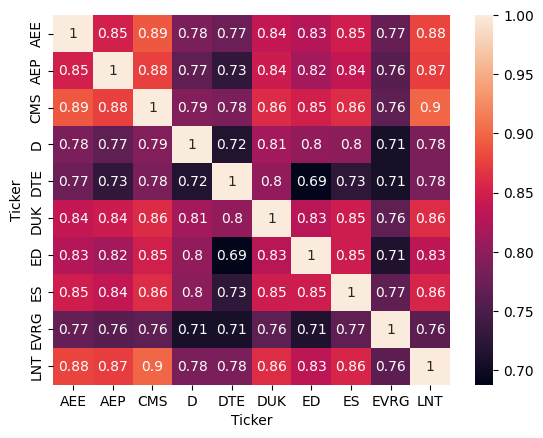

In [6]:
sns.heatmap(returns_train.corr(), annot = True)

In [7]:
spy_prices = yf.download('SPY', progress = False)['Close'].dropna()

mcaps = {}

for ticker in tickers:
    stock = yf.Ticker(ticker)
    market_cap = stock.info.get("marketCap")
    mcaps[ticker] = market_cap
    
mcaps

{'AEE': 26348511232,
 'AEP': 55871164416,
 'CMS': 21482440704,
 'D': 44945817600,
 'DTE': 26939987968,
 'DUK': 92418998272,
 'ED': 39564365824,
 'ES': 20674058240,
 'EVRG': 15300463616,
 'LNT': 15563934720}

Classic Mean-Variance

OrderedDict({'AEE': 0.9999999730293612, 'AEP': -2.5248875e-08, 'CMS': -2.1345131e-08, 'D': 1.164115591e-07, 'DTE': -1.51735618e-08, 'DUK': 1.85596669e-08, 'ED': -1.53673034e-08, 'ES': 1.6584721e-09, 'EVRG': -1.19933314e-08, 'LNT': -2.05717354e-08})


<Axes: xlabel='Weight'>

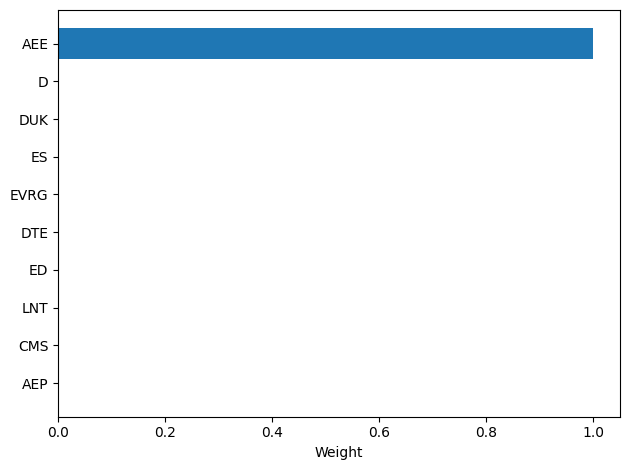

In [8]:
mu_classic = expected_returns.mean_historical_return(prices_train)
S_classic = sample_cov(prices_train)

ef_classic = EfficientFrontier(mu_classic, S_classic)
weights_classic = ef_classic.max_sharpe()
print(weights_classic)
plot_weights(weights_classic)

Robuse Mean-Variance (shrinkage)

<Axes: xlabel='Weight'>

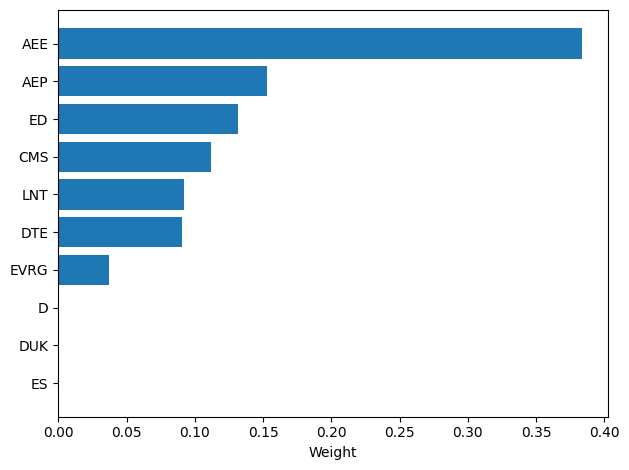

In [10]:
mu_shrink = expected_returns.mean_historical_return(prices_train)
S_shrink = CovarianceShrinkage(prices_train).shrunk_covariance(delta = 0.4)

ef_shrink = EfficientFrontier(mu_shrink, S_shrink)
weights_shrink = ef_shrink.max_sharpe()
plot_weights(weights_shrink)

Robust Mean-Variance (ledoit wolf)

<Axes: xlabel='Weight'>

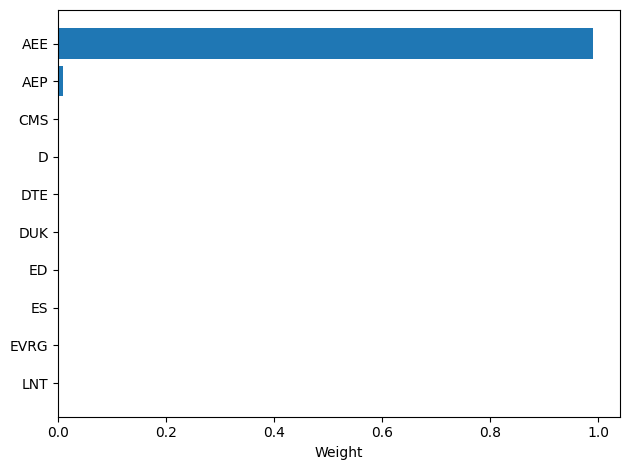

In [11]:
mu_ledoit = expected_returns.mean_historical_return(prices_train)
S_ledoit = CovarianceShrinkage(prices_train).ledoit_wolf('constant_correlation')

ef_ledoit = EfficientFrontier(mu_ledoit, S_ledoit)
weights_ledoit = ef_ledoit.max_sharpe()
plot_weights(weights_ledoit)

Efficient CVaR

In [12]:
mu_cvar = expected_returns.mean_historical_return(prices_train)
historical_returns_cvar = expected_returns.returns_from_prices(prices_train)

ef_cvar = EfficientCVaR(mu_cvar, historical_returns_cvar)
ef_cvar.min_cvar()

# We can use the same helper methods as before
weights_cvar = ef_cvar.clean_weights()
print(weights_cvar)
print(ef_cvar.portfolio_performance(verbose=True))

OrderedDict({'AEE': 0.0, 'AEP': 0.13157, 'CMS': 0.05086, 'D': 0.08922, 'DTE': 0.14038, 'DUK': 0.04911, 'ED': 0.3674, 'ES': 0.0, 'EVRG': 0.17146, 'LNT': 0.0})
Expected annual return: 9.3%
Conditional Value at Risk: 2.98%
(np.float64(0.09326348279322223), np.float64(0.02977124814739067))


Hierarchical risk parity

OrderedDict({'AEE': np.float64(0.11355458488996768), 'AEP': np.float64(0.13045339060377226), 'CMS': np.float64(0.06588961961029258), 'D': np.float64(0.12065107777668217), 'DTE': np.float64(0.12540856193106636), 'DUK': np.float64(0.12868370089700226), 'ED': np.float64(0.07367724225205062), 'ES': np.float64(0.06332578948012828), 'EVRG': np.float64(0.11560267181610494), 'LNT': np.float64(0.06275336074293283)})
Expected annual return: 11.3%
Annual volatility: 20.3%
Sharpe Ratio: 0.56


<Axes: >

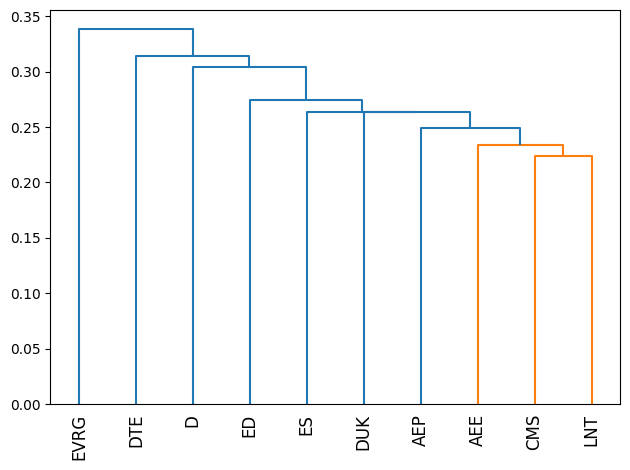

In [13]:
hrp = HRPOpt(returns_train)
weights_hrp = hrp.optimize()
print(weights_hrp)
hrp.portfolio_performance(verbose=True)
plot_dendrogram(hrp)

Black-Litterman model

In [14]:
mu_bl = expected_returns.mean_historical_return(prices_train)
S_bl = sample_cov(prices_train)
delta = black_litterman.market_implied_risk_aversion(spy_prices)
prior = black_litterman.market_implied_prior_returns(mcaps, delta, S_bl)

In [15]:
[0] * len(tickers)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [16]:
returns_train.columns

Index(['AEE', 'AEP', 'CMS', 'D', 'DTE', 'DUK', 'ED', 'ES', 'EVRG', 'LNT'], dtype='object', name='Ticker')

In [16]:
views = np.array([-0.0027, -0.0203, -0.0104, 0.0797, 0.0269, 0.0223, -0.0678, 0.1339, 0.0322, 0.0043]).reshape(-1, 1)
picking = np.array(
    [
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
        
    ]
)

bl = BlackLittermanModel(S_bl, Q=views, P=picking, pi=prior, tau=0.02)
rets_bl = bl.bl_returns()
ef_bl = EfficientFrontier(rets_bl, S_bl)
weights_bl = ef_bl.max_sharpe()
print(ef_bl.clean_weights())
ef_bl.portfolio_performance(verbose=True)

OrderedDict({'AEE': 0.0, 'AEP': 0.0, 'CMS': 0.0, 'D': 0.47668, 'DTE': 0.0, 'DUK': 0.0, 'ED': 0.0, 'ES': 0.52332, 'EVRG': 0.0, 'LNT': 0.0})
Expected annual return: 4.5%
Annual volatility: 22.0%
Sharpe Ratio: 0.20


(np.float64(0.044804038511357294),
 np.float64(0.2199807191346979),
 np.float64(0.20367257043069772))

<Axes: xlabel='Weight'>

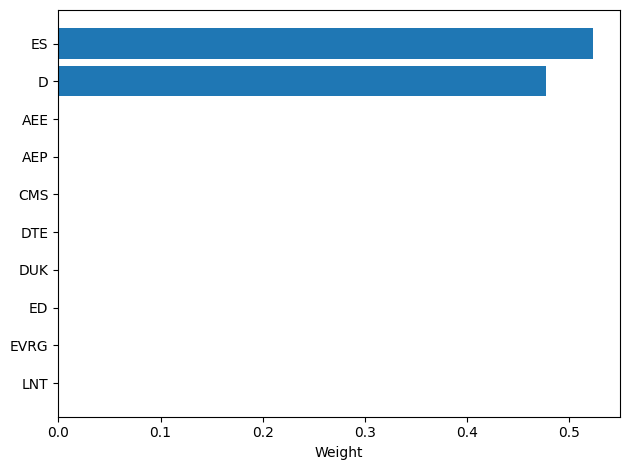

In [17]:
plot_weights(weights_bl)

In [18]:
in_sample = {
    'MV': sum(returns_train[ticker] * weights_classic[ticker] for ticker in prices.columns),
    'Ledoit': sum(returns_train[ticker] * weights_ledoit[ticker] for ticker in prices.columns),
    'Shrunk (d = 0.4)': sum(returns_train[ticker] * weights_shrink[ticker] for ticker in prices.columns),
    'Mean-CVaR': sum(returns_train[ticker] * weights_cvar[ticker] for ticker in prices.columns),
    'Black-Litterman': sum(returns_train[ticker] * weights_bl[ticker] for ticker in prices.columns),
    'HRP': sum(returns_train[ticker] * weights_hrp[ticker] for ticker in prices.columns)
}

in_sample_returns = pd.DataFrame(in_sample)
in_sample_cumulative_returns = (1 + in_sample_returns).cumprod()
in_sample_cumulative_returns_max = in_sample_cumulative_returns.cummax()
in_sample_drawdowns = (in_sample_cumulative_returns - in_sample_cumulative_returns_max)/in_sample_cumulative_returns_max

px.line(in_sample_cumulative_returns)

In [19]:
px.line(in_sample_drawdowns, title = 'Drawdowns')

In [20]:
in_sample_returns.std().sort_values().map('{:.3%}'.format)

Mean-CVaR           1.267%
HRP                 1.277%
Shrunk (d = 0.4)    1.300%
Black-Litterman     1.386%
Ledoit              1.419%
MV                  1.421%
dtype: object

In [21]:
in_sample_drawdowns.min().sort_values().map('{:.3%}'.format)

Black-Litterman     -35.097%
HRP                 -34.155%
Mean-CVaR           -33.943%
Shrunk (d = 0.4)    -31.508%
Ledoit              -29.089%
MV                  -29.086%
dtype: object

In [22]:
in_sample_cagr = (1 + in_sample_returns).prod() ** (252 / len(in_sample_returns)) - 1
in_sample_cagr.sort_values().map('{:.2%}'.format)

Black-Litterman      5.84%
HRP                  9.66%
Mean-CVaR            9.84%
Shrunk (d = 0.4)    11.96%
Ledoit              13.46%
MV                  13.48%
dtype: object

In [23]:
weights = {
    'MV': weights_classic,
    'Ledoit (constant correlation)': weights_ledoit,
    'Shrunk (d = 0.4)': weights_shrink,
    'Mean-CVaR': weights_cvar,
    'Black-Litterman': weights_bl,
    'HRP': weights_hrp
}

weights = pd.DataFrame(weights)
weights_long = weights.T.reset_index().melt(id_vars='index', var_name='Stock Ticker', value_name='Weight')

fig = px.bar(weights_long, 
             x='index', 
             y='Weight', 
             color='Stock Ticker', 
             barmode='stack',
             title='Stacked Portfolio Weights by Optimization Method',
             labels={'index': 'Optimization Method', 'Weight': 'Portfolio Weight', 'Stock Ticker': 'Stock'},
             text='Weight'
             )

fig.update_traces(texttemplate='%{text:.1%}', textposition='inside')
fig.show()

In [24]:
returns_test = prices_test.pct_change(fill_method=None).dropna()
returns_test

Ticker,AEE,AEP,CMS,D,DTE,DUK,ED,ES,EVRG,LNT
Date,,,,,,,,,,
2023-04-13,0.001445,-0.003077,0.004720,0.008119,-0.004749,-0.002716,-0.006181,-0.001880,-0.000966,0.000913
2023-04-14,-0.007103,-0.015643,-0.015228,-0.007368,-0.001767,-0.015130,-0.014274,-0.014569,-0.010961,-0.007848
2023-04-17,0.003130,0.008541,0.009048,0.012947,-0.002478,0.007886,0.012309,0.008667,0.011408,0.006623
2023-04-18,-0.016158,-0.008790,-0.013368,-0.022495,-0.005856,-0.010162,-0.003576,-0.009603,-0.005156,-0.006945
2023-04-19,0.011326,0.011571,0.018011,0.001220,0.006873,0.010163,0.006358,0.007783,0.012148,0.017483
...,...,...,...,...,...,...,...,...,...,...
2025-04-07,-0.015137,-0.027852,-0.024075,-0.036033,-0.029211,-0.017405,-0.035858,-0.047652,-0.027501,-0.025261
2025-04-08,-0.001166,-0.002855,-0.010572,-0.023018,-0.004377,-0.007787,0.006167,-0.023578,0.002331,-0.017054
2025-04-09,0.022498,0.010565,0.013392,0.052155,0.024492,0.003105,-0.002640,0.037972,0.010231,0.027726


In [25]:
out_of_sample = {
    'MV': sum(returns_test[ticker] * weights_classic[ticker] for ticker in prices.columns),
    'Ledoit': sum(returns_test[ticker] * weights_ledoit[ticker] for ticker in prices.columns),
    'Shrunk (d = 0.4)': sum(returns_test[ticker] * weights_shrink[ticker] for ticker in prices.columns),
    'Mean-CVaR': sum(returns_test[ticker] * weights_cvar[ticker] for ticker in prices.columns),
    'Black-Litterman': sum(returns_test[ticker] * weights_bl[ticker] for ticker in prices.columns),
    'HRP': sum(returns_test[ticker] * weights_hrp[ticker] for ticker in prices.columns)
}

out_of_sample_returns = pd.DataFrame(out_of_sample)
out_of_sample_cumulative_returns = (1 + out_of_sample_returns).cumprod()
out_of_sample_cumulative_returns_max = out_of_sample_cumulative_returns.cummax()
out_of_sample_drawdowns = (out_of_sample_cumulative_returns - out_of_sample_cumulative_returns_max)/out_of_sample_cumulative_returns_max

px.line(out_of_sample_cumulative_returns)

In [26]:
out_of_sample_returns.std().sort_values().map('{:.3%}'.format)

Mean-CVaR           1.063%
Shrunk (d = 0.4)    1.087%
HRP                 1.089%
Ledoit              1.235%
MV                  1.238%
Black-Litterman     1.444%
dtype: object

In [27]:
out_of_sample_drawdowns.min().sort_values().map('{:.3%}'.format)

Black-Litterman     -31.571%
MV                  -23.375%
Ledoit              -23.306%
HRP                 -19.598%
Shrunk (d = 0.4)    -19.189%
Mean-CVaR           -19.030%
dtype: object

In [28]:
out_of_sample_cagr = (1 + out_of_sample_returns).prod() ** (252 / len(out_of_sample_returns)) - 1
out_of_sample_cagr.sort_values().map('{:.2%}'.format)

Black-Litterman     -5.96%
MV                   7.57%
Ledoit               7.60%
HRP                  7.86%
Mean-CVaR            9.32%
Shrunk (d = 0.4)     9.39%
dtype: object